# S07-demo-02 – DBSCAN: плотность, шум и подбор `eps/min_samples`

В этом демо мы разбираем **DBSCAN** — алгоритм кластеризации, который:
- умеет находить **кластеры произвольной формы**;
- умеет помечать точки как **шум** (`-1`), вместо того чтобы “кластеризовать всё любой ценой”;
- не требует заранее задавать число кластеров `K`.

## Что вы освоите
- интуицию DBSCAN: *core / border / noise*;
- роль параметров `eps` и `min_samples` и почему их нельзя подбирать “на глаз”;
- почему **масштабирование признаков** может быть критично;
- практический приём для подбора `eps`: **k-distance plot**;
- как аккуратно смотреть на внутренние метрики и почему они не всегда однозначны.

## Как работать с ноутбуком
- запускайте ячейки сверху вниз: дальше используются общие переменные;
- сравнивайте сценарии “без scaling” и “со scaling”;
- помните: шум (`-1`) лучше исключать из расчёта внутренних метрик (мы делаем это в `safe_internal_metrics`).

## Воспроизводимость
Мы используем только встроенные датасеты `scikit-learn` (`make_moons`, `make_circles`, `make_blobs`), ничего скачивать не нужно.

## 0. Импорты и вспомогательные функции


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


In [2]:
def plot_points(X, title="", ax=None):
    """Базовый scatter для 2D-точек."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    ax.scatter(X[:, 0], X[:, 1], s=20)
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.grid(True, alpha=0.25)
    return ax

def plot_dbscan(X, labels, title="", ax=None):
    """Визуализация результата DBSCAN: кластеры + шум."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))

    labels = np.asarray(labels)
    unique = sorted(set(labels))

    for lab in unique:
        mask = labels == lab
        if lab == -1:
            ax.scatter(X[mask, 0], X[mask, 1], s=20, marker="x", label="noise (-1)")
        else:
            ax.scatter(X[mask, 0], X[mask, 1], s=20, label=f"cluster {lab}")

    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.grid(True, alpha=0.25)
    ax.legend(loc="best")
    return ax

def summarize_labels(labels):
    """Короткая статистика по разметке: число кластеров, доля шума."""
    labels = np.asarray(labels)
    n_noise = np.sum(labels == -1)
    n_points = len(labels)
    clusters = sorted([c for c in set(labels) if c != -1])
    return {
        "n_points": n_points,
        "n_clusters": len(clusters),
        "n_noise": int(n_noise),
        "noise_share": float(n_noise / n_points)
    }

def safe_internal_metrics(X, labels):
    """Внутренние метрики для кластеров.

    Важно:
    - silhouette корректно считать, когда есть >=2 кластера.
    - шум (-1) лучше исключать из расчёта, иначе метрика становится трудно интерпретируемой.
    """
    labels = np.asarray(labels)
    mask = labels != -1
    X2 = X[mask]
    y2 = labels[mask]

    result = {}

    # если осталось меньше 2 кластеров – метрики бессмысленны
    if len(set(y2)) < 2:
        result["silhouette"] = None
        result["calinski_harabasz"] = None
        result["davies_bouldin"] = None
        return result

    result["silhouette"] = float(silhouette_score(X2, y2))
    result["calinski_harabasz"] = float(calinski_harabasz_score(X2, y2))
    result["davies_bouldin"] = float(davies_bouldin_score(X2, y2))
    return result


## 1. Интуиция DBSCAN (коротко)

DBSCAN строит кластеры через понятие **плотности**:

- `eps` – радиус окрестности точки;
- `min_samples` – сколько точек нужно иметь в `eps`-окрестности, чтобы точка считалась **ядром** (*core*).

Типы точек:
- **core**: внутри `eps` есть хотя бы `min_samples` точек;
- **border**: сама не core, но попадает в окрестность какого-то core;
- **noise**: не core и не border (обозначается меткой `-1`).

Кластеры – это связные компоненты из core-точек (плюс их border-точки).


## 2. Датасет 1: `make_moons` (две «луны»)

Это классический пример, где **KMeans** обычно ошибается (потому что кластеры не «шарики»),  
а DBSCAN часто справляется лучше.


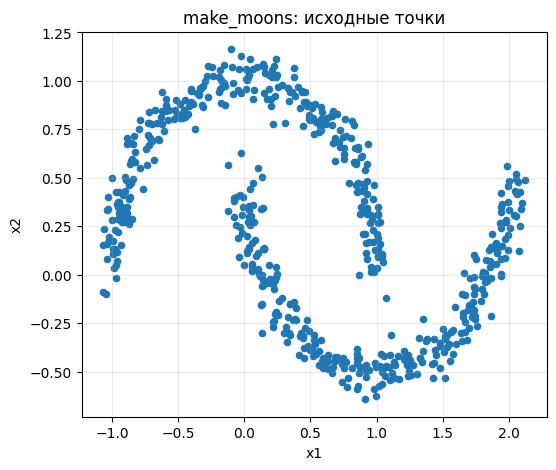

In [3]:
X_moons, _ = make_moons(n_samples=600, noise=0.06, random_state=42)

plot_points(X_moons, title="make_moons: исходные точки")
plt.show()


## 3. DBSCAN на `make_moons`: базовый запуск

Попробуем подобрать `eps` и `min_samples` «на глаз», чтобы увидеть механику.


In [4]:
db = DBSCAN(eps=0.20, min_samples=8)
labels = db.fit_predict(X_moons)

stats = summarize_labels(labels)
metrics = safe_internal_metrics(X_moons, labels)

stats, metrics


({'n_points': 600, 'n_clusters': 2, 'n_noise': 0, 'noise_share': 0.0},
 {'silhouette': 0.3305216069554034,
  'calinski_harabasz': 391.1838446476917,
  'davies_bouldin': 1.1618240664711774})

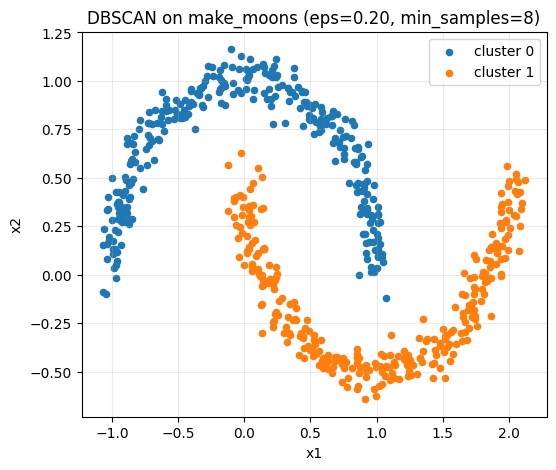

In [5]:
plot_dbscan(X_moons, labels, title="DBSCAN on make_moons (eps=0.20, min_samples=8)")
plt.show()


### Комментарий

- Если `eps` слишком маленький → почти всё станет **noise**.
- Если `eps` слишком большой → кластеры сольются в один большой.
- `min_samples` регулирует «строгость» плотности: больше `min_samples` → больше шума, меньше ложных кластеров.


## 4. Почему масштабирование важно (даже в 2D)

DBSCAN основан на расстояниях.  
Если один признак измеряется в «крупных» единицах, а другой – в «мелких», то расстояние будет доминировать одним измерением.

Сымитируем это: растянем ось `x1` в 10 раз и сравним результат **с** и **без** `StandardScaler`.


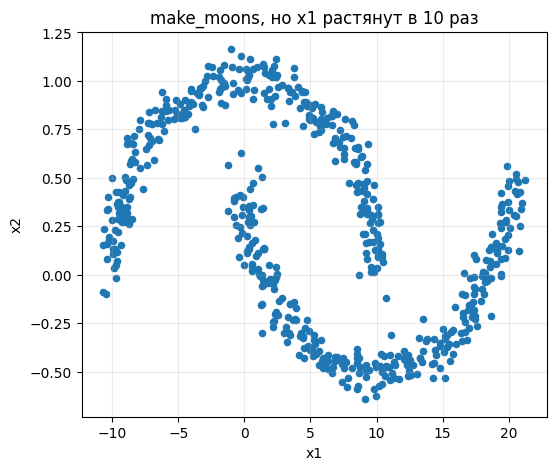

In [6]:
X_scaled_axis = X_moons.copy()
X_scaled_axis[:, 0] *= 10.0  # искусственно меняем масштаб одного признака

fig, ax = plt.subplots(figsize=(6, 5))
plot_points(X_scaled_axis, title="make_moons, но x1 растянут в 10 раз", ax=ax)
plt.show()


In [7]:
# DBSCAN на "плохом" масштабе (как есть)
db_bad = DBSCAN(eps=0.20, min_samples=8)
labels_bad = db_bad.fit_predict(X_scaled_axis)

summarize_labels(labels_bad), safe_internal_metrics(X_scaled_axis, labels_bad)


({'n_points': 600,
  'n_clusters': 18,
  'n_noise': 383,
  'noise_share': 0.6383333333333333},
 {'silhouette': 0.7005905676832285,
  'calinski_harabasz': 37593.963416361956,
  'davies_bouldin': 0.38165416948230013})

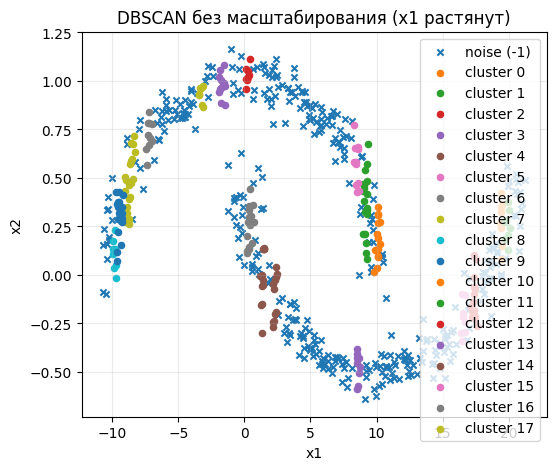

In [8]:
plot_dbscan(X_scaled_axis, labels_bad, title="DBSCAN без масштабирования (x1 растянут)")
plt.show()


In [9]:
# Теперь добавим масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_scaled_axis)

db_good = DBSCAN(eps=0.20, min_samples=8)
labels_good = db_good.fit_predict(X_scaled)

summarize_labels(labels_good), safe_internal_metrics(X_scaled, labels_good)


({'n_points': 600, 'n_clusters': 2, 'n_noise': 6, 'noise_share': 0.01},
 {'silhouette': 0.39783360468847523,
  'calinski_harabasz': 539.3803799160962,
  'davies_bouldin': 0.9982164794718092})

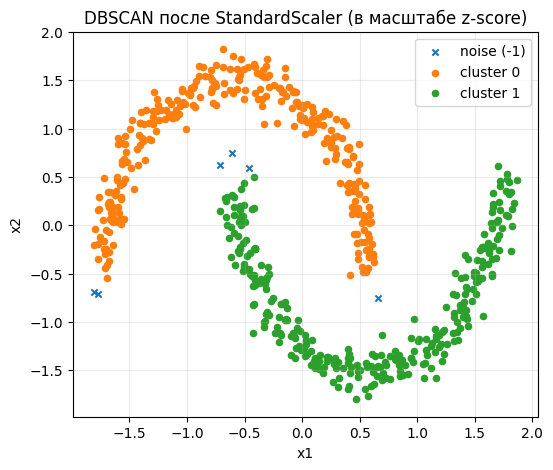

In [10]:
plot_dbscan(X_scaled, labels_good, title="DBSCAN после StandardScaler (в масштабе z-score)")
plt.show()


### Вывод

Если вы используете DBSCAN (и вообще любой метод на расстояниях), **масштабирование – часть решения**, а не «косметика».


## 5. Практический приём: k-distance plot для подбора `eps`

Идея:
1) для каждой точки считаем расстояние до её `k`-го ближайшего соседа (обычно `k = min_samples`);
2) сортируем эти расстояния по возрастанию;
3) ищем «локоть» (резкий излом) – это часто разумная оценка `eps`.

Важно: это **эвристика**, не строгая математика.


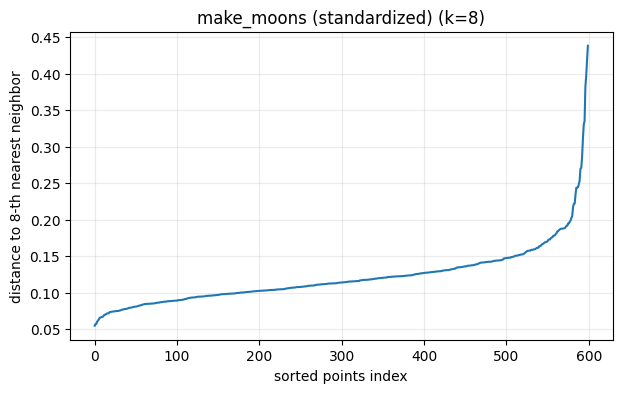

In [11]:
def k_distance_plot(X, k=8, title="k-distance plot"):
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X)
    distances, _ = nn.kneighbors(X)  # distances shape: (n_samples, k)

    kth = np.sort(distances[:, -1])  # расстояние до k-го соседа
    plt.figure(figsize=(7, 4))
    plt.plot(kth)
    plt.title(f"{title} (k={k})")
    plt.xlabel("sorted points index")
    plt.ylabel(f"distance to {k}-th nearest neighbor")
    plt.grid(True, alpha=0.25)
    plt.show()

    return kth

# Работать корректнее на нормализованных данных:
X_moons_std = StandardScaler().fit_transform(X_moons)
kth = k_distance_plot(X_moons_std, k=8, title="make_moons (standardized)")


Подберите `eps`, ориентируясь на “излом” на графике, и проверьте результат ниже.


In [12]:
# Попробуйте изменить eps (например 0.15 ... 0.35) и min_samples (например 5 ... 15)
eps = 0.22
min_samples = 8

db = DBSCAN(eps=eps, min_samples=min_samples)
labels = db.fit_predict(X_moons_std)

summarize_labels(labels), safe_internal_metrics(X_moons_std, labels)


({'n_points': 600, 'n_clusters': 2, 'n_noise': 6, 'noise_share': 0.01},
 {'silhouette': 0.3978336046884751,
  'calinski_harabasz': 539.3803799160958,
  'davies_bouldin': 0.9982164794718098})

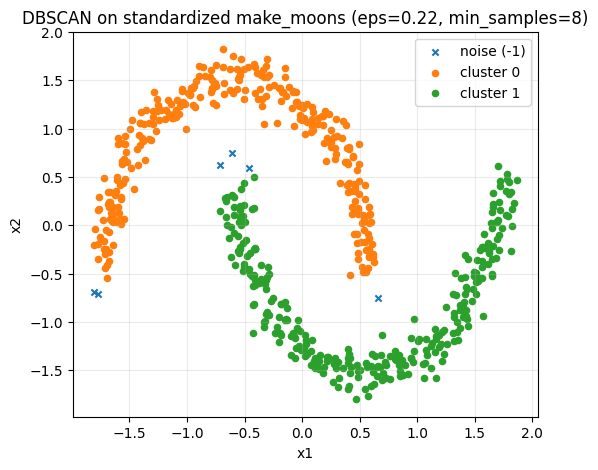

In [13]:
plot_dbscan(X_moons_std, labels, title=f"DBSCAN on standardized make_moons (eps={eps}, min_samples={min_samples})")
plt.show()


## 6. Быстрый обзор чувствительности параметров (маленький “грид”)

Задача: увидеть *паттерны ошибок*, а не найти “идеальные” параметры.

- слишком строгие параметры → много шума
- слишком мягкие → кластеры слипаются


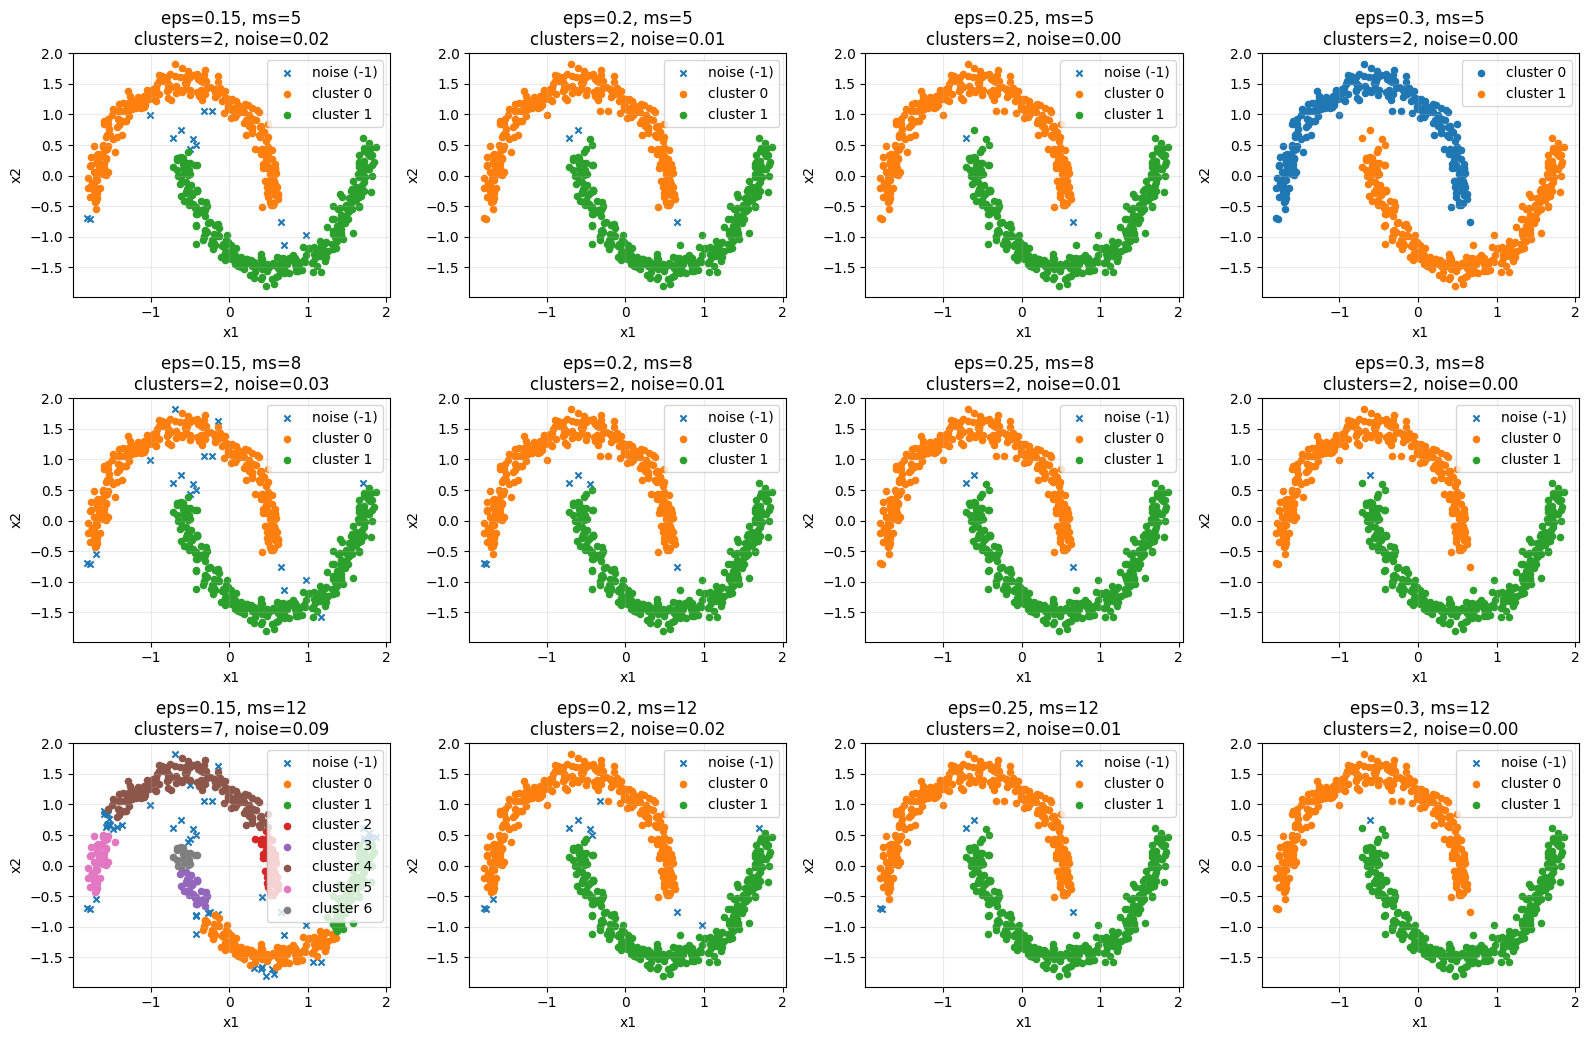

In [14]:
eps_list = [0.15, 0.20, 0.25, 0.30]
min_samples_list = [5, 8, 12]

X = X_moons_std

fig, axes = plt.subplots(len(min_samples_list), len(eps_list), figsize=(4*len(eps_list), 3.5*len(min_samples_list)))
for i, ms in enumerate(min_samples_list):
    for j, eps in enumerate(eps_list):
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X)
        stats = summarize_labels(labels)
        ax = axes[i, j]
        plot_dbscan(X, labels, title=f"eps={eps}, ms={ms}\nclusters={stats['n_clusters']}, noise={stats['noise_share']:.2f}", ax=ax)

plt.tight_layout()
plt.show()


## 7. Датасет 2: `make_circles` (вложенные окружности)

Ещё один пример кластеров «не шариками», где DBSCAN часто сильнее KMeans.


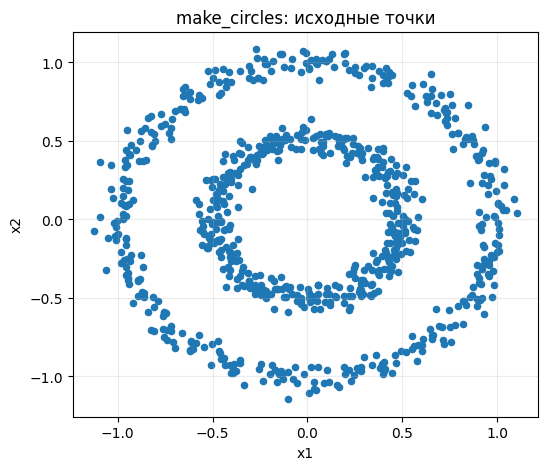

In [15]:
X_circles, _ = make_circles(n_samples=800, noise=0.05, factor=0.5, random_state=42)
X_circles_std = StandardScaler().fit_transform(X_circles)

plot_points(X_circles, title="make_circles: исходные точки")
plt.show()


In [16]:
eps = 0.25
min_samples = 10

db = DBSCAN(eps=eps, min_samples=min_samples)
labels = db.fit_predict(X_circles_std)

summarize_labels(labels), safe_internal_metrics(X_circles_std, labels)


({'n_points': 800, 'n_clusters': 2, 'n_noise': 0, 'noise_share': 0.0},
 {'silhouette': 0.11227595966297713,
  'calinski_harabasz': 0.008068175559019583,
  'davies_bouldin': 298.1127024389541})

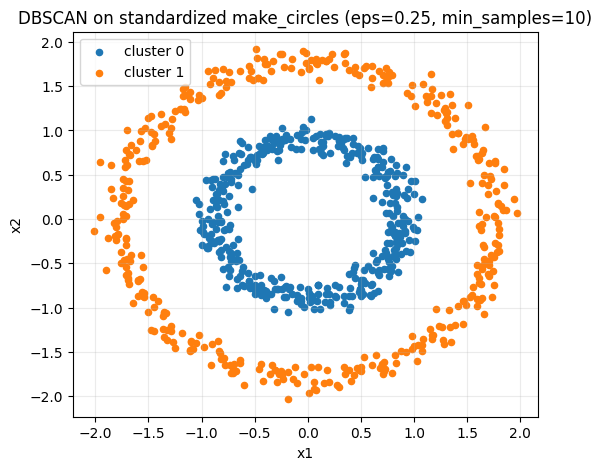

In [17]:
plot_dbscan(X_circles_std, labels, title=f"DBSCAN on standardized make_circles (eps={eps}, min_samples={min_samples})")
plt.show()


## 8. Датасет 3: разная плотность (где DBSCAN может “страдать”)

DBSCAN предполагает, что «плотность кластеров» примерно сопоставима.

Если один кластер очень плотный, а другой очень разреженный – одним `eps` может быть сложно хорошо покрыть оба.


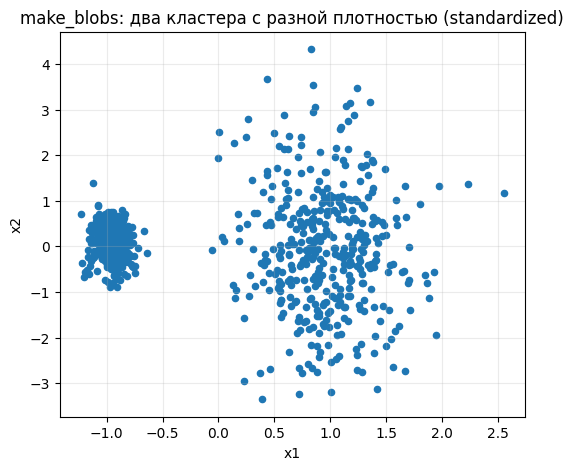

In [18]:
# Два набора blob'ов с разной дисперсией → разная плотность
X1, _ = make_blobs(n_samples=400, centers=[(-2, 0)], cluster_std=0.20, random_state=1)
X2, _ = make_blobs(n_samples=400, centers=[(2, 0)], cluster_std=0.80, random_state=2)
X_var = np.vstack([X1, X2])

X_var_std = StandardScaler().fit_transform(X_var)

plot_points(X_var_std, title="make_blobs: два кластера с разной плотностью (standardized)")
plt.show()


In [19]:
# Поиграйте eps и min_samples – иногда одним DBSCAN трудно “угодить” обеим плотностям
eps = 0.25
min_samples = 10

db = DBSCAN(eps=eps, min_samples=min_samples)
labels = db.fit_predict(X_var_std)

summarize_labels(labels), safe_internal_metrics(X_var_std, labels)


({'n_points': 800, 'n_clusters': 2, 'n_noise': 114, 'noise_share': 0.1425},
 {'silhouette': 0.6668939095040464,
  'calinski_harabasz': 1513.2811315324218,
  'davies_bouldin': 0.5665021297526713})

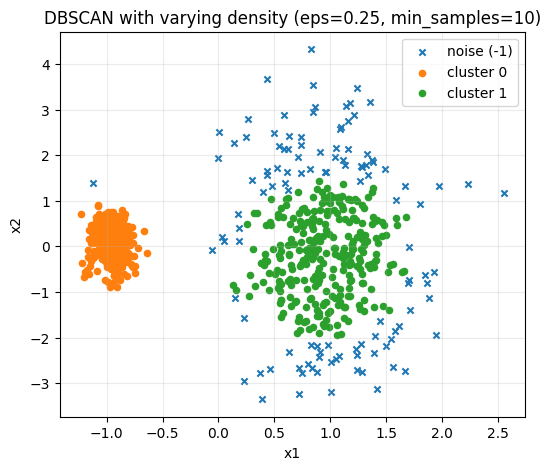

In [20]:
plot_dbscan(X_var_std, labels, title=f"DBSCAN with varying density (eps={eps}, min_samples={min_samples})")
plt.show()


### Что из этого следует

DBSCAN – отличный базовый метод для:
- кластеров произвольной формы,
- задач с выбросами,
- когда `K` неизвестно.

Но у него есть ограничения:
- чувствительность к `eps/min_samples`,
- сложности при **разной плотности** кластеров,
- зависимость от метрики расстояния и масштабирования.

## Мини-чеклист (самопроверка)

- Я понимаю смысл `eps` и `min_samples`.
- Я вижу, как меняется доля шума при разных параметрах.
- Я понимаю, почему `StandardScaler` может радикально менять результат.
- Я умею построить k-distance plot и использовать его как эвристику для `eps`.
